# PSD Analysis Alpha R

## Load necessary libraries
If any of these don't load, you'll need to install them. Assuming you installed Jupyter through Anaconda, you would do the following to install a package
`conda install -c r r-[pkgName]`
e.g., to install ggplot2 you would do:
`conda install -c r r-ggplot2`

In [1]:
R.home()

[1] "/opt/conda/lib/R"

In [2]:
R.version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [3]:
library(ggplot2)
library(mgcv)
library(parallel)
library(plyr)
library(tidyr)
library(data.table)
library(viridis)
# library(ggthemes)
library(nlme)

Loading required package: nlme
This is mgcv 1.8-29. For overview type 'help("mgcv-package")'.
Loading required package: viridisLite


## Load Data

In [4]:
topdir = getwd()
source(paste(topdir,'/NCIL_functions.R',sep=""))
num_cores = 4

dat = read.csv("osc_data/alpha.csv")

head(dat)

X,Subj,PSD,Stim,Channel,Condition,Region,Band,Electrode_by_Subj,Stim_by_Subj,Cond_by_Subj
<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0,1,-122.8223,standard,POz,MW1,occipital,alpha,POz_1,standard_1,MW1_1
1,1,-120.1373,standard,POz,MW1,occipital,alpha,POz_1,standard_1,MW1_1
2,1,-119.1676,standard,POz,MW1,occipital,alpha,POz_1,standard_1,MW1_1
3,1,-121.0747,standard,POz,MW1,occipital,alpha,POz_1,standard_1,MW1_1
4,1,-119.7060,standard,POz,MW1,occipital,alpha,POz_1,standard_1,MW1_1
5,1,-123.8453,standard,POz,MW1,occipital,alpha,POz_1,standard_1,MW1_1


In [5]:
summary(dat)

       X              Subj            PSD                Stim      
 Min.   :    0   Min.   : 1.00   Min.   :-138.77   oddball :10439  
 1st Qu.:17956   1st Qu.:12.00   1st Qu.:-122.42   standard:61386  
 Median :35912   Median :24.00   Median :-119.45                   
 Mean   :35912   Mean   :23.99   Mean   :-119.19                   
 3rd Qu.:53868   3rd Qu.:36.00   3rd Qu.:-116.22                   
 Max.   :71824   Max.   :47.00   Max.   : -99.69                   
                                                                   
    Channel      Condition         Region         Band       Electrode_by_Subj
 CPz    : 5525   MW1:22334   frontal  :27625   alpha:71825   CPz_43 :  154    
 F3     : 5525   MW2:24960   occipital:22100                 F3_43  :  154    
 F4     : 5525   MW3: 3419   parietal :22100                 F4_43  :  154    
 Fp1    : 5525   MW4:15613                                   Fp1_43 :  154    
 Fp2    : 5525   MW5: 5499                                   

## Run initial full model to identify and remove outliers

Now run the model

In [6]:
m0 <- bam(PSD ~ Stim * Condition
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

In [7]:
dat <- romr.fnc(m0, dat, trim=2.5)$data

m1 <- bam(PSD ~ Stim * Condition 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

n.removed = 1075 
percent.removed = 1.496693 


#### Find and remove outliers, then update model


Method: fREML   Optimizer: perf newton
full convergence after 10 iterations.
Gradient range [-0.0001973024,0.0001952041]
(score 212926.2 & scale 21.9941).
Hessian positive definite, eigenvalue range [0.4967433,35908.5].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.997    0.64  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


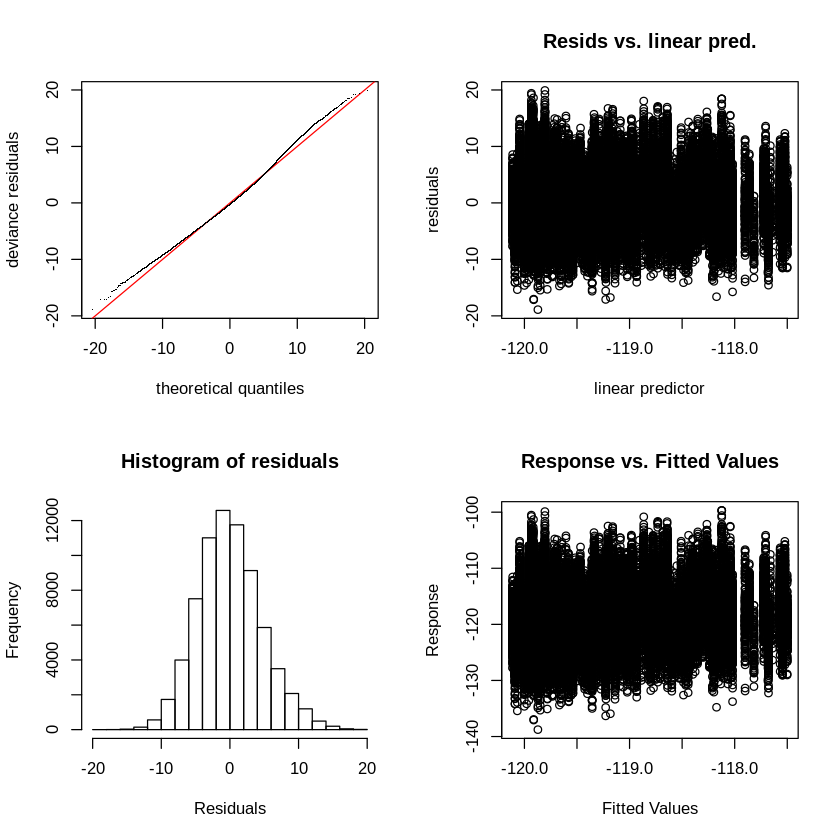

In [8]:
gam.check(m0)


Method: fREML   Optimizer: perf newton
full convergence after 11 iterations.
Gradient range [-1.254582e-05,1.247255e-05]
(score 205619.4 & scale 19.57557).
Hessian positive definite, eigenvalue range [0.4980751,35371].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.998    0.65  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


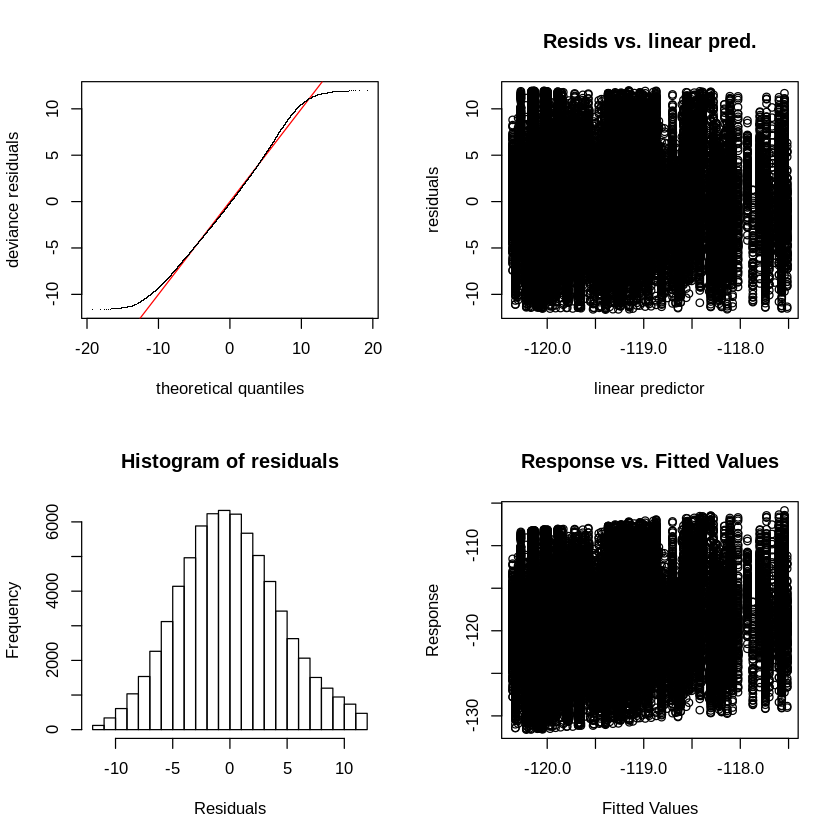

In [9]:
gam.check(m1)

## Compute LME based on model StimType * MentalState
- We will start by clustering around MW1 Standard
- We see the original amplified P2 effect disappear
- It is possible that this was an effect of the contrasts between conditions
- When MW, oddball responses are high; oddballs are significantly lower when on task
- Differences might be greater at Fz based on preliminary analysis of grand averages

In [10]:
bdat <- dat

In [11]:
dat <- bdat

In [12]:
dat <- subset(bdat, Region == 'occipital') #change this as needed

# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

In [13]:
summary(dat)

       X              Subj            PSD               Stim      
 Min.   :    0   Min.   : 1.00   Min.   :-131.5   standard:18630  
 1st Qu.:17738   1st Qu.:12.00   1st Qu.:-123.3   oddball : 3178  
 Median :35846   Median :24.00   Median :-120.3                   
 Mean   :35699   Mean   :23.98   Mean   :-120.1                   
 3rd Qu.:53700   3rd Qu.:36.00   3rd Qu.:-117.0                   
 Max.   :71806   Max.   :47.00   Max.   :-105.9                   
                                                                  
    Channel     Condition        Region         Band       Electrode_by_Subj
 Oz     :5468   MW1:6808   frontal  :    0   alpha:21808   O1_43  :  154    
 O1     :5455   MW2:7590   occipital:21808                 O2_43  :  154    
 O2     :5454   MW3:1037   parietal :    0                 Oz_43  :  154    
 POz    :5431   MW4:4715                                   POz_43 :  154    
 CPz    :   0   MW5:1658                                   Oz_12  :  149    
 F

### Try many models

In [14]:
num_cores = 4

cl <- makeCluster(num_cores)

m1r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m3r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m4r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Stim_by_Subj, bs="re"), 
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m5r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m6r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m7r <- bam(PSD ~ Stim  # adding this to control for condition
           + s(Condition, bs="re")
           + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

### Select best model based on AIC

In [15]:
AICtab = as.data.frame(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r,m7r))
minAIC =  min(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r,m7r)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m5r,299.447685,112289.8,0.0000,1.000000e+00
m4r,230.358321,112947.7,657.8870,7.216763e+142
m1r,194.292749,113025.2,735.4166,4.939461e+159
m7r,193.295443,114878.1,2588.3376,Inf
m6r,195.316715,114880.0,2590.2557,Inf
m3r,173.073888,114896.0,2606.2327,Inf
m2r,99.952913,115447.8,3158.0571,Inf
m0,9.999988,425836.4,313546.5983,Inf


### Get summary of the best model
Main effects and interactions. 

In [16]:
mod = m5r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df     F p-value
Stim            1 1.228  0.2678
Condition       4 3.694  0.0052
Stim:Condition  2 0.421  0.6566

Approximate significance of smooth terms:
                          edf   Ref.df        F p-value
s(Subj)                0.9028   1.0000    0.903 0.00133
s(Electrode_by_Subj) 177.4606 187.0000 1513.170 < 2e-16
s(Cond_by_Subj)      111.5857 168.0000  320.392 < 2e-16

In [17]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                           Estimate Std. Error  t value Pr(>|t|)    
(Intercept)              -121.42166    0.46452 -261.392  < 2e-16 ***
Stimoddball                -0.11714    0.10570   -1.108  0.26778    
ConditionMW2                0.21252    0.25222    0.843  0.39946    
ConditionMW3                0.08335    0.29682    0.281  0.77886    
ConditionMW4                0.78799    0.27918    2.823  0.00477 ** 
ConditionMW5                1.06366    0.38050    2.795  0.00519 ** 
Stimoddball:ConditionMW2    0.00000    0.00000       NA       NA    
Stimoddball:ConditionMW3    0.00000    0.00000       NA       NA    
Stimoddball:ConditionMW4   -0.14974    0.16397   -0.913  0.36116    
Stimoddball:ConditionMW5   -0.08145    0.23241   -0.350  0.72601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0

### Visualize these results

In [18]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Niether MW nor OT)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),0.21,0.252,0.84,-0.42,0.84,0.39946,0.7989
3 (Niether MW nor OT),0.08,0.297,0.83,-0.66,0.28,0.77886,0.7989
4 (Somewhat MW),0.79,0.279,1.49,0.09,2.82,0.00477,0.0191
5 (Completely MW),1.06,0.381,2.02,0.11,2.80,0.00519,0.0191


Saving 6.67 x 6.67 in image


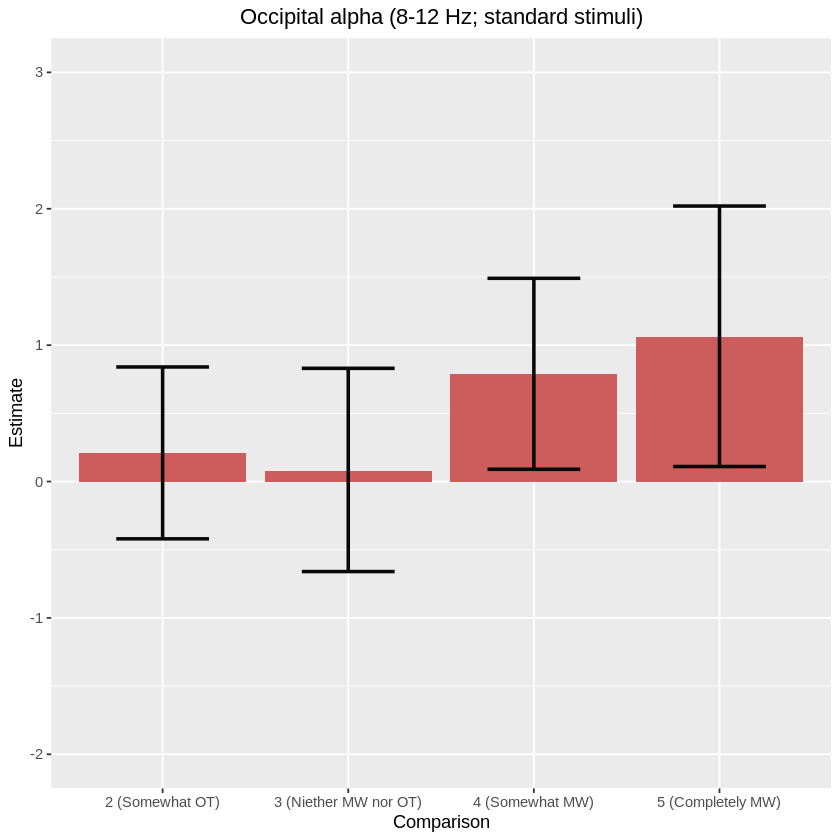

In [19]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='indianred' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-2,3) + 
        ggtitle("Occipital alpha (8-12 Hz; standard stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison")

ggsave(filename='standard-alpha.png', dpi=600)

### Compare MW1 oddball instead

In [20]:
# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'oddball')

cl <- makeCluster(num_cores)

m7r <- bam(PSD ~ Stim * Condition
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [21]:
mod = m7r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df     F p-value
Stim            1 1.228  0.2678
Condition       3 2.965  0.0307
Stim:Condition  3 0.495  0.6856

Approximate significance of smooth terms:
                          edf   Ref.df       F p-value
s(Subj)                0.9028   1.0000 98741.1 0.00133
s(Electrode_by_Subj) 177.4606 187.0000  1510.1 < 2e-16
s(Cond_by_Subj)      111.5857 168.0000   323.8 < 2e-16

In [22]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                            Estimate Std. Error  t value Pr(>|t|)    
(Intercept)               -121.53880    0.47259 -257.175   <2e-16 ***
Stimstandard                 0.11714    0.10570    1.108   0.2678    
ConditionMW2                 0.00000    0.00000       NA       NA    
ConditionMW3                 0.08335    0.29682    0.281   0.7789    
ConditionMW4                 0.63825    0.30986    2.060   0.0394 *  
ConditionMW5                 0.98222    0.42589    2.306   0.0211 *  
Stimstandard:ConditionMW2    0.21252    0.25222    0.843   0.3995    
Stimstandard:ConditionMW3    0.00000    0.00000       NA       NA    
Stimstandard:ConditionMW4    0.14974    0.16397    0.913   0.3612    
Stimstandard:ConditionMW5    0.08145    0.23241    0.350   0.7260    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’

### Visualize the results

In [23]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Niether MW nor OT)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),0.00,0.000,0.00,0.00,NaN,NaN,NaN
3 (Niether MW nor OT),0.08,0.297,0.83,-0.66,0.28,0.77886,1.0000
4 (Somewhat MW),0.64,0.310,1.41,-0.14,2.06,0.03943,0.1183
5 (Completely MW),0.98,0.426,2.05,-0.08,2.31,0.02111,0.0844


Saving 6.67 x 6.67 in image


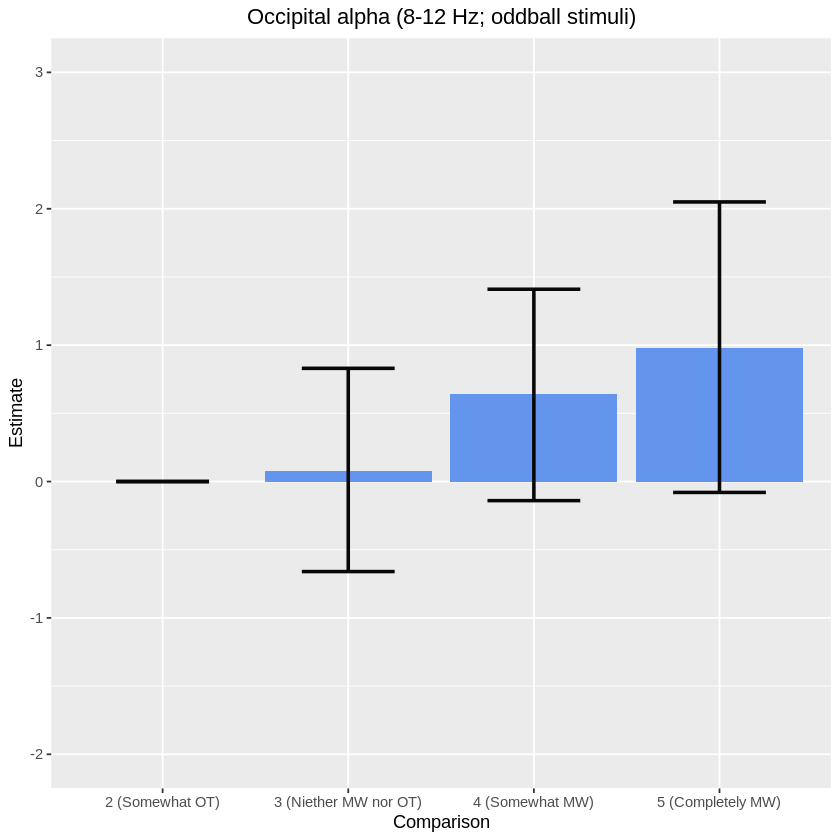

In [24]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='cornflowerblue' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ggtitle("Occipital alpha (8-12 Hz; oddball stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison") + 
        ylim(-2,3)

ggsave(filename='oddball-alpha.png', dpi=600)

## Compare standards and oddballs for each condition
Could have put this in a loop, but this is the path of least resistance

In [25]:
# set up initial posthoc

dat <- subset(bdat, Region == 'occipital') #change this as needed

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

cl <- makeCluster(num_cores)

m8r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

mod = m8r

res <- t(summary(mod)$p.table[2,])
res <- as.data.frame(res)
res$Condition = paste("1 (Completely OT)")
posthocs <- res

# include the subsequent levels, looping through
mw_levels <- c('MW2','MW3','MW4','MW5')
axis_labels <- c('2 (Somewhat OT)', '3 (Neither MW nor OT)', '4 (Somewhat MW)', '5 (Completely MW)')

for(i in 1:4){
    dat[,'Condition'] <- relevel(dat[,'Condition'],mw_levels[i])
    dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

    cl <- makeCluster(num_cores)

    m8r <- bam(PSD ~ Stim * Condition  
               + s(Subj, bs="re") 
               + s(Electrode_by_Subj, bs="re")  
               + s(Cond_by_Subj, bs="re"),
              data = dat, 
              samfrac=0.1, cluster=cl, gc.level=2)

    stopCluster(cl)

    mod = m8r

    res <- t(summary(mod)$p.table[2,])
    res <- as.data.frame(res)
    res$Condition = paste(axis_labels[i])
    posthocs <- rbind(posthocs, res)
}

In [26]:
## Clean up posthocs

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1 (Completely OT),-0.12,0.106,0.16,-0.39,-1.11,0.26778,0.5356
2 (Somewhat OT),-0.27,0.125,0.06,-0.59,-2.13,0.03326,0.1663
3 (Neither MW nor OT),-0.27,0.125,0.06,-0.59,-2.13,0.03326,0.1663
4 (Somewhat MW),-0.27,0.125,0.06,-0.59,-2.13,0.03326,0.1663
5 (Completely MW),-0.20,0.207,0.34,-0.73,-0.96,0.33734,0.5356


Saving 6.67 x 6.67 in image


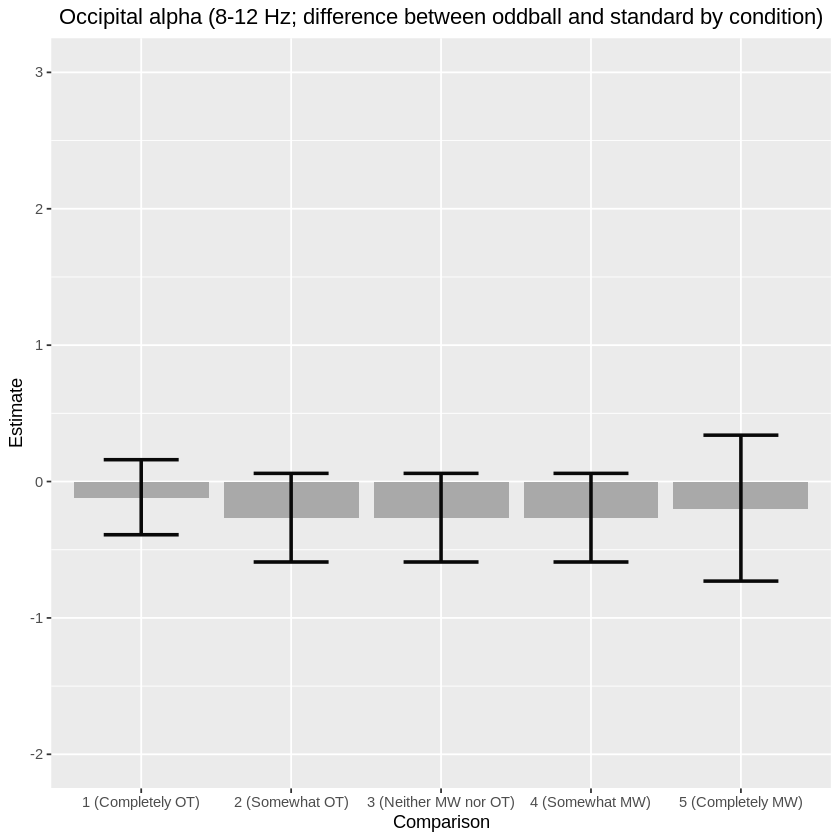

In [27]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='darkgray' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ggtitle("Occipital alpha (8-12 Hz; difference between oddball and standard by condition)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison") + 
        ylim(-2,3)

ggsave(filename='oddball-difference-alpha.png', dpi=600)